In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '생수'만 빼서 df생성
item = '생수'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

# MAD기법 적용할꺼면.....

In [43]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

In [5]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
lowVIF(w,40,list_col)

,VIF_Factor,features
0,3.715302,temp
1,4.682044,PM10
2,6.314379,cloud
3,7.886587,lgt_time
4,8.692697,wind


In [6]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만, 
# 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
# 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
# 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
combined = gs_day_w.loc[:,list_col+['rain_or_not','snow_or_not']]
target = gs_day_w.loc[:,'qty']

In [7]:
combined.head(2)

,temp,cloud,wind,lgt_time,PM10,rain_or_not,snow_or_not
0,1.2,7.0,1.6,2.1,68.696500,비x,눈x
1,5.7,7.8,2.0,3.6,53.618667,비x,눈x


In [8]:
Xy = pd.concat([target,combined], axis=1)

In [9]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [10]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 5
오브젝트형 자료 컬럼 갯수 : 2


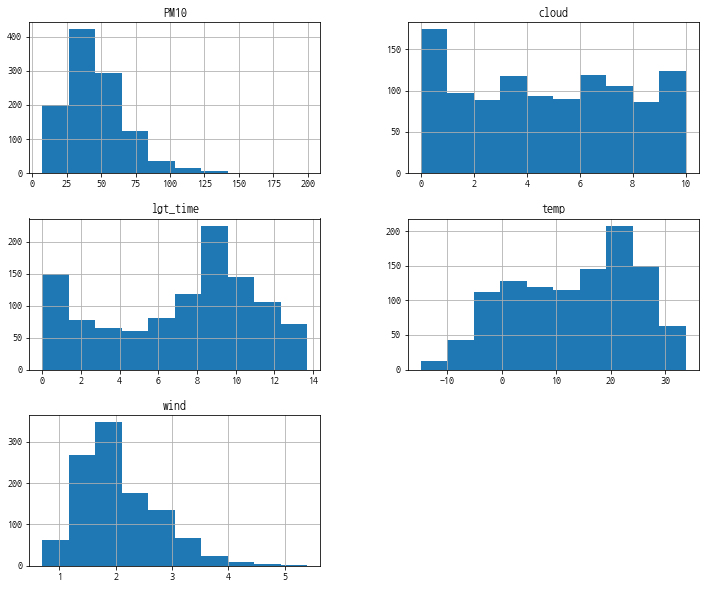

In [11]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

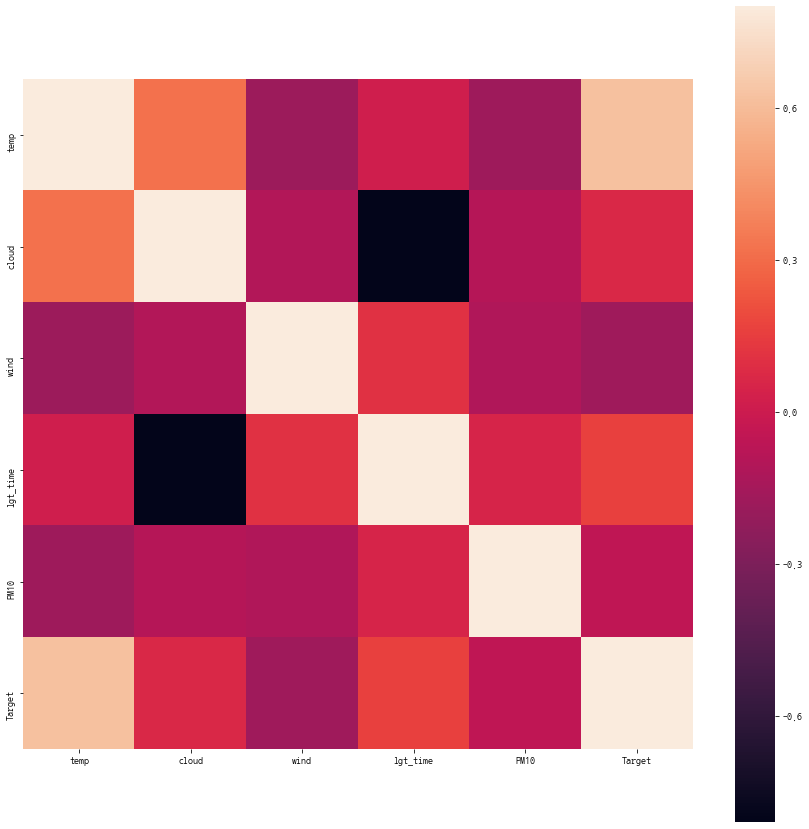

In [12]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [13]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 9 개의 columns이 있었습니다.


In [14]:
# 비o,비x는 하나가 1이면 다른하나는 0은 완저히 베타적인 관계이므로 한개를 삭제
# 눈o눈x,도 비와 같다.
combined.drop(['rain_or_not_비x'],axis = 1 , inplace=True)
combined.drop(['snow_or_not_눈x'],axis = 1 , inplace=True)
combined.head(1)

,temp,cloud,wind,lgt_time,PM10,rain_or_not_비o,snow_or_not_눈o
0,1.2,7.0,1.6,2.1,68.6965,0,0


In [15]:
combined.columns = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o',
       'snow_or_not_o']

In [16]:
Xy = pd.concat([target,combined], axis=1)
Xy.head(1)

,qty,temp,cloud,wind,lgt_time,PM10,rain_or_not_o,snow_or_not_o
0,6269,1.2,7.0,1.6,2.1,68.6965,0,0


In [17]:
# (combined.shape[0] * 2)//3 첫 2/3 : 730
# 하루정도 차이 있겠지만, 2년/1년
cut_line = (combined.shape[0] * 2)//3
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(730, 7)

In [18]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0719 12:32:58.159380  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 12:32:58.175337  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 12:32:58.178329  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0719 12:32:58.235205  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

checkpoint_name

'GS-생수date-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# xxxyyzzz.hdf5 자료가 주워 졌음 ↓ 요건 실행 안해도 된다.

In [20]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0719 12:33:09.215734  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0719 12:33:09.331454  9660 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 584 samples, validate on 146 samples
Epoch 1/500
584/584 [==============================] - 0s 542us/step - loss: 10371.8078 - mean_absolute_error: 10371.8078 - val_loss: 9122.2305 - val_mean_absolute_error: 9122.2305

Epoch 00001: val_loss improved from inf to 9122.23047, saving model to GS-생수date-Weights-001--9122.23047-cat02-vf05.hdf5
Epoch 2/500
584/584 [==============================] - 0s 80us/step - loss: 9518.1791 - mean_absolute_error: 9518.1791 - val_loss: 6639.3632 - val_mean_absolute_error: 6639.3632

Epoch 00002: val_loss improved from 9122.23047 to 6639.36318, saving model to GS-생수date-Weights-002--6639.36318-cat02-vf05.hdf5
Epoch 3/500
584/584 [==============================] - 0s 87us/step - loss: 4094.9012 - mean_absolute_error: 4094.9012 - val_loss: 2373.6190 - val_mean_absolute_error: 2373.6190

Epoch 00003: val_loss improved from 6639.36318 to 2373.61901, saving model to GS-생수date-Weights-003--2373.61901-cat02-vf05.hdf5
Epoch 4/500
584/584 [================

584/584 [==============================] - 0s 73us/step - loss: 1649.7384 - mean_absolute_error: 1649.7384 - val_loss: 1328.4829 - val_mean_absolute_error: 1328.4829

Epoch 00031: val_loss did not improve from 1295.98765
Epoch 32/500
584/584 [==============================] - 0s 84us/step - loss: 1674.0204 - mean_absolute_error: 1674.0204 - val_loss: 1317.8096 - val_mean_absolute_error: 1317.8096

Epoch 00032: val_loss did not improve from 1295.98765
Epoch 33/500
584/584 [==============================] - 0s 77us/step - loss: 1663.0132 - mean_absolute_error: 1663.0132 - val_loss: 1359.3248 - val_mean_absolute_error: 1359.3248

Epoch 00033: val_loss did not improve from 1295.98765
Epoch 34/500
584/584 [==============================] - 0s 73us/step - loss: 1653.9513 - mean_absolute_error: 1653.9513 - val_loss: 1394.5058 - val_mean_absolute_error: 1394.5058

Epoch 00034: val_loss did not improve from 1295.98765
Epoch 35/500
584/584 [==============================] - 0s 77us/step - loss: 

584/584 [==============================] - 0s 89us/step - loss: 1614.9654 - mean_absolute_error: 1614.9654 - val_loss: 1271.8152 - val_mean_absolute_error: 1271.8152

Epoch 00065: val_loss did not improve from 1268.95650
Epoch 66/500
584/584 [==============================] - 0s 94us/step - loss: 1606.2607 - mean_absolute_error: 1606.2607 - val_loss: 1296.1415 - val_mean_absolute_error: 1296.1415

Epoch 00066: val_loss did not improve from 1268.95650
Epoch 67/500
584/584 [==============================] - 0s 89us/step - loss: 1602.4307 - mean_absolute_error: 1602.4307 - val_loss: 1310.0489 - val_mean_absolute_error: 1310.0489

Epoch 00067: val_loss did not improve from 1268.95650
Epoch 68/500
584/584 [==============================] - 0s 96us/step - loss: 1606.0810 - mean_absolute_error: 1606.0810 - val_loss: 1376.9807 - val_mean_absolute_error: 1376.9807

Epoch 00068: val_loss did not improve from 1268.95650
Epoch 69/500
584/584 [==============================] - 0s 97us/step - loss: 


Epoch 00098: val_loss did not improve from 1242.87249
Epoch 99/500
584/584 [==============================] - 0s 117us/step - loss: 1635.2177 - mean_absolute_error: 1635.2177 - val_loss: 1338.3440 - val_mean_absolute_error: 1338.3440

Epoch 00099: val_loss did not improve from 1242.87249
Epoch 100/500
584/584 [==============================] - 0s 119us/step - loss: 1567.3723 - mean_absolute_error: 1567.3723 - val_loss: 1306.2896 - val_mean_absolute_error: 1306.2896

Epoch 00100: val_loss did not improve from 1242.87249
Epoch 101/500
584/584 [==============================] - 0s 99us/step - loss: 1571.8320 - mean_absolute_error: 1571.8320 - val_loss: 1303.8143 - val_mean_absolute_error: 1303.8143

Epoch 00101: val_loss did not improve from 1242.87249
Epoch 102/500
584/584 [==============================] - 0s 97us/step - loss: 1560.7965 - mean_absolute_error: 1560.7965 - val_loss: 1249.0715 - val_mean_absolute_error: 1249.0715

Epoch 00102: val_loss did not improve from 1242.87249
Epoc

584/584 [==============================] - 0s 126us/step - loss: 1544.7779 - mean_absolute_error: 1544.7779 - val_loss: 1175.7759 - val_mean_absolute_error: 1175.7759

Epoch 00132: val_loss improved from 1184.03425 to 1175.77594, saving model to GS-생수date-Weights-132--1175.77594-cat02-vf05.hdf5
Epoch 133/500
584/584 [==============================] - 0s 138us/step - loss: 1516.8234 - mean_absolute_error: 1516.8234 - val_loss: 1247.2198 - val_mean_absolute_error: 1247.2198

Epoch 00133: val_loss did not improve from 1175.77594
Epoch 134/500
584/584 [==============================] - 0s 130us/step - loss: 1498.6767 - mean_absolute_error: 1498.6767 - val_loss: 1215.3136 - val_mean_absolute_error: 1215.3136

Epoch 00134: val_loss did not improve from 1175.77594
Epoch 135/500
584/584 [==============================] - 0s 135us/step - loss: 1522.2005 - mean_absolute_error: 1522.2005 - val_loss: 1230.9427 - val_mean_absolute_error: 1230.9427

Epoch 00135: val_loss did not improve from 1175.77


Epoch 00165: val_loss did not improve from 1158.85068
Epoch 166/500
584/584 [==============================] - 0s 132us/step - loss: 1456.1229 - mean_absolute_error: 1456.1229 - val_loss: 1359.5719 - val_mean_absolute_error: 1359.5719

Epoch 00166: val_loss did not improve from 1158.85068
Epoch 167/500
584/584 [==============================] - 0s 135us/step - loss: 1455.7552 - mean_absolute_error: 1455.7552 - val_loss: 1191.9947 - val_mean_absolute_error: 1191.9947

Epoch 00167: val_loss did not improve from 1158.85068
Epoch 168/500
584/584 [==============================] - 0s 126us/step - loss: 1434.8228 - mean_absolute_error: 1434.8228 - val_loss: 1387.4458 - val_mean_absolute_error: 1387.4458

Epoch 00168: val_loss did not improve from 1158.85068
Epoch 169/500
584/584 [==============================] - 0s 164us/step - loss: 1496.9017 - mean_absolute_error: 1496.9017 - val_loss: 1177.7820 - val_mean_absolute_error: 1177.7820

Epoch 00169: val_loss did not improve from 1158.85068
E

584/584 [==============================] - 0s 156us/step - loss: 1469.0676 - mean_absolute_error: 1469.0676 - val_loss: 1217.5621 - val_mean_absolute_error: 1217.5621

Epoch 00200: val_loss did not improve from 1147.55569
Epoch 201/500
584/584 [==============================] - 0s 131us/step - loss: 1435.2363 - mean_absolute_error: 1435.2363 - val_loss: 1205.0047 - val_mean_absolute_error: 1205.0047

Epoch 00201: val_loss did not improve from 1147.55569
Epoch 202/500
584/584 [==============================] - 0s 150us/step - loss: 1430.8284 - mean_absolute_error: 1430.8284 - val_loss: 1148.7584 - val_mean_absolute_error: 1148.7584

Epoch 00202: val_loss did not improve from 1147.55569
Epoch 203/500
584/584 [==============================] - ETA: 0s - loss: 1383.6945 - mean_absolute_error: 1383.694 - 0s 147us/step - loss: 1428.4898 - mean_absolute_error: 1428.4898 - val_loss: 1276.9881 - val_mean_absolute_error: 1276.9881

Epoch 00203: val_loss did not improve from 1147.55569
Epoch 204/

584/584 [==============================] - 0s 124us/step - loss: 1398.6893 - mean_absolute_error: 1398.6893 - val_loss: 1114.7179 - val_mean_absolute_error: 1114.7179

Epoch 00234: val_loss improved from 1116.91814 to 1114.71788, saving model to GS-생수date-Weights-234--1114.71788-cat02-vf05.hdf5
Epoch 235/500
584/584 [==============================] - 0s 159us/step - loss: 1480.9400 - mean_absolute_error: 1480.9400 - val_loss: 1595.1768 - val_mean_absolute_error: 1595.1768

Epoch 00235: val_loss did not improve from 1114.71788
Epoch 236/500
584/584 [==============================] - 0s 161us/step - loss: 1430.7785 - mean_absolute_error: 1430.7785 - val_loss: 1111.3018 - val_mean_absolute_error: 1111.3018

Epoch 00236: val_loss improved from 1114.71788 to 1111.30177, saving model to GS-생수date-Weights-236--1111.30177-cat02-vf05.hdf5
Epoch 237/500
584/584 [==============================] - 0s 143us/step - loss: 1386.1834 - mean_absolute_error: 1386.1834 - val_loss: 1274.9624 - val_mean_abs

584/584 [==============================] - 0s 178us/step - loss: 1349.5117 - mean_absolute_error: 1349.5117 - val_loss: 1271.5000 - val_mean_absolute_error: 1271.5000

Epoch 00268: val_loss did not improve from 1111.30177
Epoch 269/500
584/584 [==============================] - 0s 152us/step - loss: 1380.0260 - mean_absolute_error: 1380.0260 - val_loss: 1234.4671 - val_mean_absolute_error: 1234.4671

Epoch 00269: val_loss did not improve from 1111.30177
Epoch 270/500
584/584 [==============================] - 0s 145us/step - loss: 1448.7548 - mean_absolute_error: 1448.7548 - val_loss: 1171.9423 - val_mean_absolute_error: 1171.9423

Epoch 00270: val_loss did not improve from 1111.30177
Epoch 271/500
584/584 [==============================] - 0s 155us/step - loss: 1430.6628 - mean_absolute_error: 1430.6628 - val_loss: 1171.2569 - val_mean_absolute_error: 1171.2569

Epoch 00271: val_loss did not improve from 1111.30177
Epoch 272/500
584/584 [==============================] - 0s 172us/step

584/584 [==============================] - 0s 133us/step - loss: 1372.2111 - mean_absolute_error: 1372.2111 - val_loss: 1455.5542 - val_mean_absolute_error: 1455.5542

Epoch 00302: val_loss did not improve from 1095.75844
Epoch 303/500
584/584 [==============================] - 0s 140us/step - loss: 1440.4201 - mean_absolute_error: 1440.4201 - val_loss: 1141.0476 - val_mean_absolute_error: 1141.0476

Epoch 00303: val_loss did not improve from 1095.75844
Epoch 304/500
584/584 [==============================] - 0s 143us/step - loss: 1396.6465 - mean_absolute_error: 1396.6465 - val_loss: 1453.1417 - val_mean_absolute_error: 1453.1417

Epoch 00304: val_loss did not improve from 1095.75844
Epoch 305/500
584/584 [==============================] - 0s 159us/step - loss: 1368.1260 - mean_absolute_error: 1368.1260 - val_loss: 1124.5295 - val_mean_absolute_error: 1124.5295

Epoch 00305: val_loss did not improve from 1095.75844
Epoch 306/500
584/584 [==============================] - 0s 155us/step

584/584 [==============================] - 0s 135us/step - loss: 1371.2594 - mean_absolute_error: 1371.2594 - val_loss: 1462.5375 - val_mean_absolute_error: 1462.5375

Epoch 00337: val_loss did not improve from 1095.75844
Epoch 338/500
584/584 [==============================] - 0s 139us/step - loss: 1340.6882 - mean_absolute_error: 1340.6882 - val_loss: 1255.6354 - val_mean_absolute_error: 1255.6354

Epoch 00338: val_loss did not improve from 1095.75844
Epoch 339/500
584/584 [==============================] - 0s 162us/step - loss: 1360.0743 - mean_absolute_error: 1360.0743 - val_loss: 1376.1633 - val_mean_absolute_error: 1376.1633

Epoch 00339: val_loss did not improve from 1095.75844
Epoch 340/500
584/584 [==============================] - 0s 157us/step - loss: 1353.4626 - mean_absolute_error: 1353.4626 - val_loss: 1068.7655 - val_mean_absolute_error: 1068.7655

Epoch 00340: val_loss improved from 1095.75844 to 1068.76549, saving model to GS-생수date-Weights-340--1068.76549-cat02-vf05.h

584/584 [==============================] - 0s 161us/step - loss: 1308.9035 - mean_absolute_error: 1308.9035 - val_loss: 1419.1315 - val_mean_absolute_error: 1419.1315

Epoch 00371: val_loss did not improve from 1068.76549
Epoch 372/500
584/584 [==============================] - 0s 171us/step - loss: 1316.6224 - mean_absolute_error: 1316.6224 - val_loss: 1567.7323 - val_mean_absolute_error: 1567.7323

Epoch 00372: val_loss did not improve from 1068.76549
Epoch 373/500
584/584 [==============================] - 0s 172us/step - loss: 1329.3103 - mean_absolute_error: 1329.3103 - val_loss: 1110.6595 - val_mean_absolute_error: 1110.6595

Epoch 00373: val_loss did not improve from 1068.76549
Epoch 374/500
584/584 [==============================] - 0s 193us/step - loss: 1438.7884 - mean_absolute_error: 1438.7884 - val_loss: 1915.2459 - val_mean_absolute_error: 1915.2459

Epoch 00374: val_loss did not improve from 1068.76549
Epoch 375/500
584/584 [==============================] - 0s 174us/step


Epoch 00405: val_loss did not improve from 1068.76549
Epoch 406/500
584/584 [==============================] - 0s 145us/step - loss: 1335.6850 - mean_absolute_error: 1335.6850 - val_loss: 1141.5447 - val_mean_absolute_error: 1141.5447

Epoch 00406: val_loss did not improve from 1068.76549
Epoch 407/500
584/584 [==============================] - 0s 157us/step - loss: 1396.2727 - mean_absolute_error: 1396.2727 - val_loss: 1478.7064 - val_mean_absolute_error: 1478.7064

Epoch 00407: val_loss did not improve from 1068.76549
Epoch 408/500
584/584 [==============================] - 0s 140us/step - loss: 1318.9792 - mean_absolute_error: 1318.9792 - val_loss: 1351.4667 - val_mean_absolute_error: 1351.4667

Epoch 00408: val_loss did not improve from 1068.76549
Epoch 409/500
584/584 [==============================] - 0s 152us/step - loss: 1330.3203 - mean_absolute_error: 1330.3203 - val_loss: 1233.6770 - val_mean_absolute_error: 1233.6770

Epoch 00409: val_loss did not improve from 1068.76549
E

584/584 [==============================] - 0s 154us/step - loss: 1337.3249 - mean_absolute_error: 1337.3249 - val_loss: 1314.1833 - val_mean_absolute_error: 1314.1833

Epoch 00440: val_loss did not improve from 1068.76549
Epoch 441/500
584/584 [==============================] - 0s 164us/step - loss: 1277.5545 - mean_absolute_error: 1277.5545 - val_loss: 1648.2380 - val_mean_absolute_error: 1648.2380

Epoch 00441: val_loss did not improve from 1068.76549
Epoch 442/500
584/584 [==============================] - 0s 162us/step - loss: 1334.4752 - mean_absolute_error: 1334.4752 - val_loss: 1163.2447 - val_mean_absolute_error: 1163.2447

Epoch 00442: val_loss did not improve from 1068.76549
Epoch 443/500
584/584 [==============================] - 0s 162us/step - loss: 1319.0317 - mean_absolute_error: 1319.0317 - val_loss: 1746.9685 - val_mean_absolute_error: 1746.9685

Epoch 00443: val_loss did not improve from 1068.76549
Epoch 444/500
584/584 [==============================] - 0s 161us/step

584/584 [==============================] - 0s 181us/step - loss: 1313.2956 - mean_absolute_error: 1313.2956 - val_loss: 1335.2107 - val_mean_absolute_error: 1335.2107

Epoch 00475: val_loss did not improve from 1068.76549
Epoch 476/500
584/584 [==============================] - 0s 174us/step - loss: 1275.2455 - mean_absolute_error: 1275.2455 - val_loss: 1472.0991 - val_mean_absolute_error: 1472.0991

Epoch 00476: val_loss did not improve from 1068.76549
Epoch 477/500
584/584 [==============================] - 0s 190us/step - loss: 1354.0176 - mean_absolute_error: 1354.0176 - val_loss: 1754.7730 - val_mean_absolute_error: 1754.7730

Epoch 00477: val_loss did not improve from 1068.76549
Epoch 478/500
584/584 [==============================] - 0s 183us/step - loss: 1295.9405 - mean_absolute_error: 1295.9405 - val_loss: 1464.5527 - val_mean_absolute_error: 1464.5527

Epoch 00478: val_loss did not improve from 1068.76549
Epoch 479/500
584/584 [==============================] - 0s 179us/step

# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

In [21]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = 'GS-생수date-Weights-340--1068.76549-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [22]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.880
검증세트점수 : -0.191
XGBoost을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.804
검증세트점수 : 0.162
LinearRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.415
검증세트점수 : 0.133
RidgeRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.412
검증세트점수 : 0.130
LassoRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.415
검증세트점수 : 0.133
OLS을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.415


In [23]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
list_col = ['temp', 'lgt_time', 'PM10', 'snow_or_not_o', 'rain_or_not_o']

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
olsModel.summary()

생수 ols model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     100.9
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           1.05e-80
Time:                        12:34:25   Log-Likelihood:                -6740.8
No. Observations:                 730   AIC:                         1.349e+04
Df Residuals:                     724   BIC:                         1.352e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6613.6516    359.728     18.385      0.000    5907.417    7319.886
temp            184.9933      8.955     20.658      0.000     167.412     202.574
lgt_time        111.9856     27.889      4.015      0.000      57.233     166.739
PM10              7.1114      4.184      1.700      0.090      -1.102      15.325
snow_or_not_o    79.5483    584.198      0.136      0.892   -1067.376    1226.472
rain_or_not_o  -188.2214    256.179     -0.735      0.463    -691.164     314.721
==============================================================================
Omnibus:                      988.208   Durbin-Watson:                   1.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248036.508
Skew:                           6.973   Prob(JB):                         0.00
Kurtosis:                      92.219   Cond. No.                         351.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

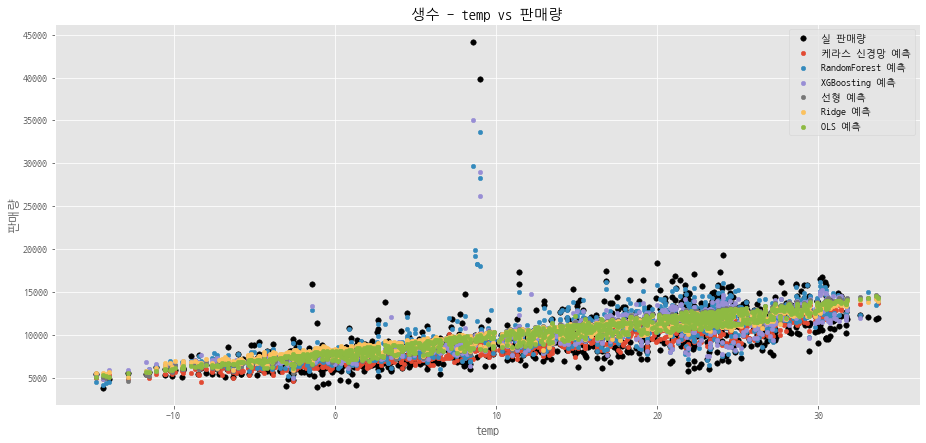

In [34]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_비o', 'snow_or_not_눈o']
n=1
# alpha 값 0~1
alp = 1
# scatter plot 점 크기
dot_size = 20

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=30, c='k', alpha = 1)
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

## 실험 구간

In [ ]:

# # 2016~2017 : 훈련 / 2018 검증 2:1
# trainXy = gs_week_w.loc[:cut_line]
# testXy = gs_week_w.loc[cut_line:]
# train_X =pd.DataFrame(trainXy.loc[:,'temp'])
# train_y = trainXy.loc[:,'qty']
# val_X = pd.DataFrame(testXy.loc[:,'temp'])
# val_y = testXy.loc[:,'qty']



# print('여기서 점수란 R-square값을 의미한다.')
# # RandomForest 회귀분석
# RFmodel = RandomForestRegressor()
# RFmodel.fit(train_X,train_y)
# # Get the mean absolute error on the validation data
# RFpredicted = RFmodel.predict(val_X)
# MAE = mean_absolute_error(val_y , RFpredicted)
# print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# # print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# # XGBRegressor 회귀분석
# XGBModel = XGBRegressor(objective='reg:squarederror')
# XGBModel.fit(train_X,train_y , verbose=False)
# # Get the mean absolute error on the validation data :
# XGBpredictions = XGBModel.predict(val_X)
# MAE = mean_absolute_error(val_y , XGBpredictions)
# print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# # print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

# linReg = LinearRegression().fit(train_X, train_y)
# print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

# ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
# print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

# lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
# print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
# print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

# customF = formulaGen(target='qty',ind_features=['temp'])
# olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
# print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

# combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
# target = gs_week_w.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# # predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# result_df = pd.DataFrame()
# result_df['week'] = gs_week_w['week']
# result_df['qty'] = gs_week_w.loc[:,'qty']

# # print("keras 신경망 predictions",predictions.shape)
# # result_df['keras_qty'] = predictions

# # print("randomforest 예상",RFpredicted.shape)
# result_df['rf_qty'] = RFpredicted

# # print("XGBpredictions",XGBpredictions.shape)
# result_df['xgb_qty'] = XGBpredictions

# # print("linearRegression 예상",RFpredicted.shape)
# result_df['lin_qty'] = linPred

# # print("Ridge 예상",RFpredicted.shape)
# result_df['ridge_qty'] = ridPred

# # print("Lasso 예상",RFpredicted.shape)
# result_df['lasso_qty'] = lassoPred

# # print("OLS 예상",RFpredicted.shape)
# result_df['ols_qty'] = olsPred

# ============================================

In [ ]:
# df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
# for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
# df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# # df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# qty_columns = list(df_graph.columns)[1:9]
# weather_columns = list(df_graph.columns)[9:]
# print(qty_columns)
# print(weather_columns)

In [ ]:
# x_temp = pd.DataFrame()
# # x_temp['temp'] = list(range(-10,35,1))
# x_temp['temp'] = np.arange(-9,35,0.5)
# combined = x_temp
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
# plt.plot(x_temp, RFpredicted, label = 'rf')
# plt.plot(x_temp, XGBpredictions, label = 'xgb')
# plt.plot(x_temp, linPred, label = 'line')
# plt.plot(x_temp, ridPred, label = 'ridge')
# plt.plot(x_temp, lassoPred, label = 'lasso')
# plt.plot(x_temp, olsPred, label = 'ols')
# plt.plot()
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 실험

In [ ]:
# intercept_lin = linReg.intercept_
# coef_line = linReg.coef_
# # list_col
# linePredict = list()
# x_temp = list(range(-10,38,1))
# for temperature in x_temp:
#     linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# # for q_name in qty_columns:
# #     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
# #     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
# #     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# #     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# #     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# #     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# #     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 시간의 경과에 따른 예측량 비교

In [ ]:
# # 2016
# df_graph = result_df.loc[result_df.week <=53]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# # 2017
# df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2018
# df_graph = result_df.loc[(result_df.week >=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2016~2018
# plt.figure(figsize=(15.5, 10))
# plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# def r2_score(v_true, v_pred):
#     ssr = np.sum(np.square(v_pred - np.mean(v_true)))
#     sst = np.sum(np.square(v_true - np.mean(v_true)))
#     return ( ssr / sst)

In [ ]:
# checked_for = '2016~2017'
# combined = aaaaa.loc[:106,'temp':'PM10']
# target = aaaaa.loc[:106,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)
# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2018'
# combined = aaaaa.loc[106:,'temp':'PM10']
# target = aaaaa.loc[106:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2016~2018'
# combined = aaaaa.loc[:,'temp':'PM10']
# target = aaaaa.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# path = 'D:/project/contest/data/result/'
# result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)